HHU Deep Representation Learning, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 8 - Protein Structure Prediction


---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1.

This is a **two week exercise**. If we feel like you have genuinely tried to solve the exercise, you will receive **2** points for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 12.07.2025 </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/O5rhpWBdmwWnvnA](https://uni-duesseldorf.sciebo.de/s/O5rhpWBdmwWnvnA)

---

## Contents

1. Package installations and imports
2. Post-process attention maps
3. Predict contacts from attention maps
4. Data loading
5. Train a linear layer to predict contact maps from ESM embeddings

---

# Introduction

In this assignment you will use the pretrained [ESM](https://github.com/facebookresearch/esm) protein language model to predict protein contacts.

# Part I. Package installations and imports

In [1]:
!pip install biopython biotite
!pip install seaborn
!curl --create-dirs --output-dir ./data -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1a3a_1_A.a3m
!curl --output-dir ./data -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/5ahw_1_A.a3m
!curl --output-dir ./data -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1xcr_1_A.a3m

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147k  100  147k    0     0   243k      0 --:--:-- --:--:-- --:--:--  243k0     0   243k      0 --:--:-- --:--:-- --:--:--  243k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0   305k      0 --:--:-- --:--:-- --:--:--  306k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181k  100  181k    0     0   405k      0 --:--:-- --:--:-- --:--:--  405k


In [2]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from biotite.database import rcsb
from biotite.structure.io.pdbx import CIFFile, get_structure
from torch import nn
from tqdm.notebook import tqdm

from utils import evaluate_prediction, plot_contacts_and_predictions, contacts_from_pdb, \
    read_msa, ESMStructuralSplitDataset, BatchConverterContact, \
    plot_stats, test_func

In [3]:
# Download and load the models
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)
figs_dir = Path("./figs")
figs_dir.mkdir(exist_ok=True)
data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)


def get_model(name):
    model, alphabet = torch.hub.load("facebookresearch/esm:main", name)
    batch_converter = alphabet.get_batch_converter()
    model.eval()
    head = model.contact_head.regression
    return model, alphabet, batch_converter, head


# Download the models. This can take some time (~9GB of weights)
get_model(name="esm2_t33_650M_UR50D")
model, alphabet, batch_converter, head = get_model(name="esm1_t34_670M_UR50S")
# print(f"padding_idx:{model.padding_idx}, cls_idx:{model.cls_idx}, eos_idx:{model.eos_idx}, mask_idx:{model.mask_idx}")

Using cache found in /Users/taha.kassabi/.cache/torch/hub/facebookresearch_esm_main
Using cache found in /Users/taha.kassabi/.cache/torch/hub/facebookresearch_esm_main


The `get_model` function also returns a `batch_converter`, which takes a list of (protein name, amino acid sequence) tuples and returns a tokenized batch including padding and special tokens.
The relevant special tokens are `alphabet.cls_token` (if `alphabet.prepend_bos` is `True`), `alphabet.eos_token` (if `alphabet.append_eos` is `True`) as well `alphabet.mask_token`.
(These values are also attributes of the model, e.g. `model.cls_idx`.)

The forward function requires the parameter `need_head_weights=True` to return the attention maps in the `results` dictionary.

In [4]:
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein3", "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_mask = (batch_tokens != alphabet.padding_idx)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    model = model.to(DEVICE)
    batch_tokens = batch_tokens.to(DEVICE)
    results = model(batch_tokens, need_head_weights=True)

print(
    f"The model returns the attention maps for all layers and heads with shape [batch_size, layers, heads, seq_length, seq_length]  == {results['attentions'].shape}")
print(f"as well as the output representations for each token/residue in the seq with shape [batch_size, seq_length, d_model]  == {results['logits'].shape}")

The model returns the attention maps for all layers and heads with shape [batch_size, layers, heads, seq_length, seq_length]  == torch.Size([2, 34, 20, 66, 66])
as well as the output representations for each token/residue in the seq with shape [batch_size, seq_length, d_model]  == torch.Size([2, 66, 35])


# Part II. Post-process attention maps

The attention maps -- unlike the contact maps -- are generally not symmetric.
We symmetrize an attention map $A \in [0, 1]^{L \times L}$ by computing
$$A^\text{sym} = A + A^\top.$$
To reduce biases for specific positions we use a form of average product correction (APC), which is defined as
$$
\begin{aligned}
a_i &= \sum_{j=1}^L A_{ij} \quad\text{ for } i = 1, \ldots, L \\
a &= \sum_{i=1}^L\sum_{j=1}^L A_{ij} \\
A^\text{APC}_{ij} &= A_{ij} - \frac{a_i a_j}{a}.
\end{aligned}
$$
The input of the functions `symmetrize` and `apc` can have arbitrary many batch and channel dimensions in the front, make sure to only apply the operations to the last two dimensions (use `dim=-1` and `dim=-2` in the appropriate places).

The `postprocess_attention` function takes the attention maps of shape `(batch_size, layers, heads, L, L)` and performs the following steps:
- If appropiate (`append_eos` is `True`), the eos token attentions are removed.
This is done by setting the corresponding attention values to zero and removing the last row and column of the attention maps.
- If appropiate (`remove_cls` is `True`), the cls token attentions are removed by removing the first row and column of the attention maps.
- Only keep the last `last_n_layers` layers. If `last_n_layers` is `None`, all layers are kept.
- Apply the `symmetrize` and `apc` functions in that order.
- Reshape and permute as necessary to obtain a tensor of shape `(batch_size, L', L', last_n_layers * heads)`,
where `L'` is the sequence length after possibly removing eos and cls tokens.



In [5]:
def symmetrize(x):
    """Make x symmetric in final two dimensions, used for contact prediction."""
    ### START CODE HERE ### (≈ 1 lines of code)
    return x + x.mT
    ### END CODE HERE ###


def apc(x):
    """Perform average product correct, used for contact prediction."""
    ### START CODE HERE ### (4-6 lines of code)
    a = x.sum(-1)
    a = torch.einsum('...i,...j->...ij', a, a)
    a /= x.sum((-2, -1), keepdims=True)
    return x - a
    ### END CODE HERE ###


def postprocess_attention(attentions, append_eos=False, eos_idx=None, tokens=None, remove_cls=True, last_n_layers=None):
    if append_eos:
        assert eos_idx is not None, 'Specify eos_idx'
        assert tokens is not None, 'Specify tokens'
        eos_mask = (tokens != eos_idx).to(attentions)
        eos_mask = eos_mask.unsqueeze(1) * eos_mask.unsqueeze(2)
        attentions = attentions * eos_mask[:, None, None, :, :]
        # remove eos token attentions
        ### START CODE HERE ### (1 line of code)
        attentions = attentions[..., :-1, :-1]
        ### END CODE HERE ###

    # remove cls token attentions
    # typically the first token in the sequence as in NLP and computer vision tasks
    if remove_cls:
        ### START CODE HERE ###
        attentions = attentions[..., 1:, 1:]
        ### END CODE HERE ###

    # remove attention from all but last n layers
    if last_n_layers is not None:
        ### START CODE HERE ###
        attentions = attentions[..., -last_n_layers:, :, :, :]
        ### END CODE HERE ###
    # apply symmetrize and apc:
    # returned output should be of shape (batch_size, seqlen, seqlen, layers * heads) but any order of these dimensions is fine
    ### START CODE HERE ###
    attentions = symmetrize(attentions)
    attentions = apc(attentions)
    attentions = attentions.permute(*range(attentions.dim() - 4), -2, -1, -4, -3).flatten(-2)
    ### END CODE HERE ### 
    return attentions


test_func(symmetrize)
test_func(apc)
test_func(postprocess_attention)

Function symmetrize passed all tests!
Function apc passed all tests!
Function postprocess_attention passed all tests!


Now we can visualize the mean attention maps for the two sequences in the batch above

This model does not have the eos token: model.append_eos is  False
contact_maps.shape = torch.Size([2, 65, 65, 680]), mean_map.shape = (2, 65, 65)
(2, 65, 65) tensor([66,  7]) ('protein3', 'K A <mask> I S Q')


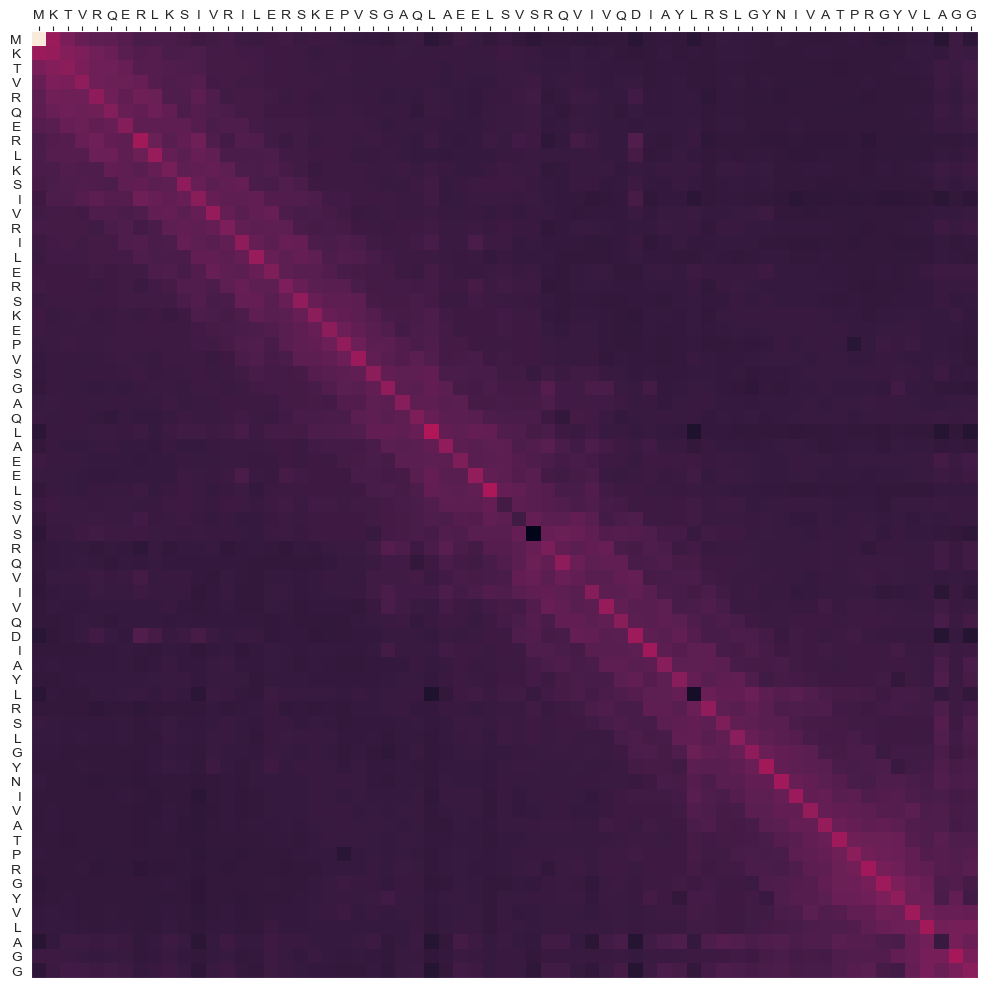

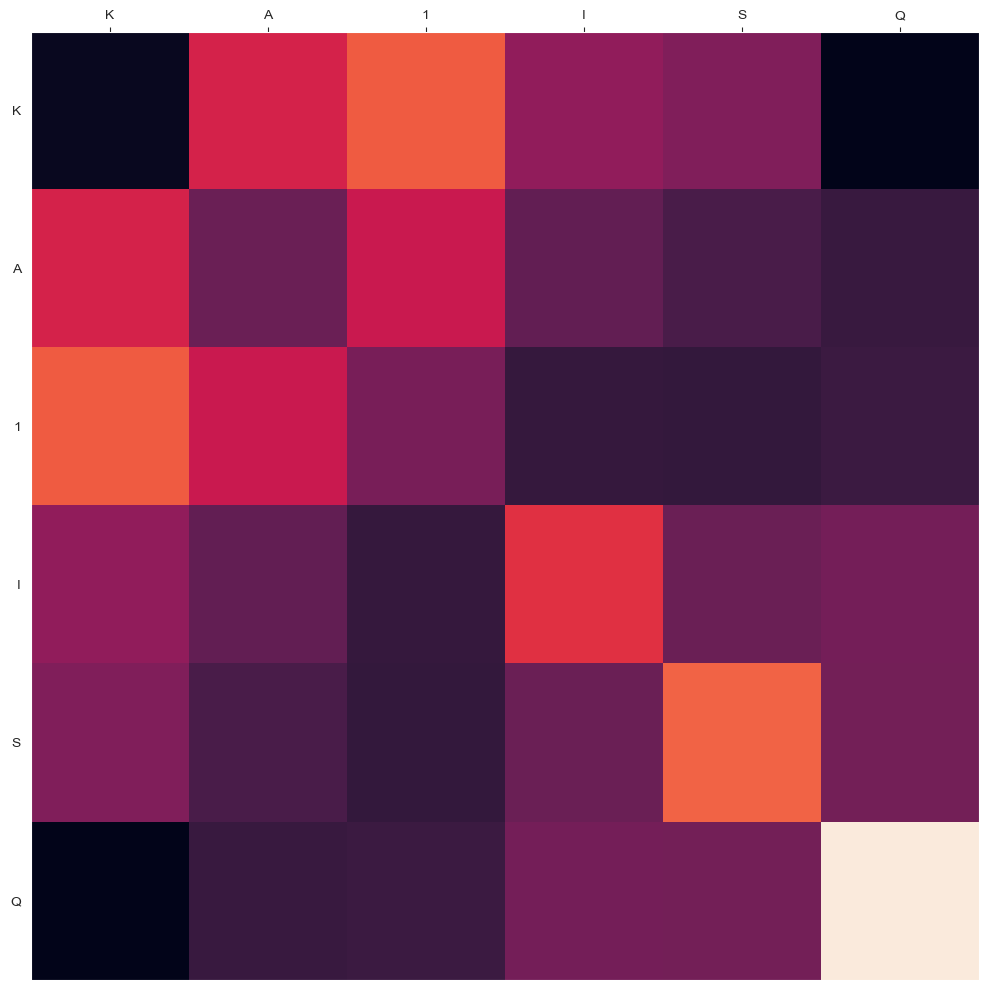

In [6]:
print("This model does not have the eos token: model.append_eos is ", model.append_eos)
contact_maps = postprocess_attention(results['attentions'], remove_cls=True,
                                     append_eos=model.append_eos, eos_idx=alphabet.eos_idx, tokens=batch_tokens)
sequence_name = data[-1]
mean_map = contact_maps.mean(-1).cpu().numpy()
print(f"contact_maps.shape = {contact_maps.shape}, mean_map.shape = {mean_map.shape}")
print(mean_map.shape, batch_lens, data[-1])
for (_, seq), tokens_len, matrix in zip(data, batch_lens, mean_map):
    # Visualize the mean self-attention map for contact prediction for both sequences
    ### START CODE HERE ###
    seq = tuple(seq.replace('<mask>', '1').replace(' ', ''))
    matrix = matrix[:len(seq), :len(seq)]

    plt.figure(figsize=(10,) * 2)
    plt.imshow(matrix)

    plt.gca().xaxis.tick_top()
    plt.xticks(range(len(seq)), seq)
    plt.yticks(range(len(seq)), seq)
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    ### END CODE HERE ###

# Part III. Predict contacts from attention maps

In [7]:
# We load the three sequences we downloaded at the beginning of the notebook
def get_data(PDB_IDS):
    structures = {
        name.lower(): get_structure(CIFFile.read(rcsb.fetch(name, "cif", data_dir)))[0]
        for name in PDB_IDS}
    contacts = {name: contacts_from_pdb(structure, chain="A")
                for name, structure in structures.items()}
    msas = {name: read_msa(data_dir / f"{name.lower()}_1_A.a3m")
            for name in PDB_IDS}
    sequences = {name: msa[0] for name, msa in msas.items()}
    return sequences, contacts


PDB_IDS = ["1a3a", "5ahw", "1xcr"]
sequences, contacts = get_data(PDB_IDS)
print(sequences)

{'1a3a': ('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'), '5ahw': ('', 'SAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS'), '1xcr': ('', 'CAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD')}


We will now test the two ESM models with their trained linear heads to predict contacts from the attention maps.

The `predict_contact_maps` function must do the following steps:
- Convert the sequence to tokens (remember that `batch_converter` expects a list of sequences)
- Pass the tokens through the model and obtain the attention maps and apply postprocessing
- If `head` is `None`, compute the mean attention map over all heads and return it
- Otherwise, apply the `head` to the attention maps followed by a sigmoid and return the result

In [8]:
def predict_contact_maps(model, alphabet, batch_converter, sequence, device, head=None):
    """Predict contact maps from a single sequence.
    If head is None, the mean attention map will be computed.

    Returns a tensor of shape (L,L)
    """
    ### START CODE HERE ### (≈ 6 lines of code)
    _, _, batch_tokens = batch_converter([sequence])
    batch_tokens = batch_tokens.to(device)
    results = model(batch_tokens, need_head_weights=True)

    contact_maps = postprocess_attention(results['attentions'].squeeze(0), remove_cls=True,
                                         append_eos=model.append_eos, eos_idx=alphabet.eos_idx, tokens=batch_tokens)
    print(contact_maps.shape)
    return head(contact_maps).squeeze(0, -1) if head else contact_maps.mean(-1).squeeze(0)
    ### END CODE HERE ###


@torch.no_grad()
def predict_unsup_maps(model, alphabet, batch_converter, sequences, device, head=None):
    if head is None:
        print("Warning: mean attention maps will be computed as contact maps")
    predictions = {}
    results = []
    model.eval()
    model.to(device)

    for name, inputs in sequences.items():
        out = predict_contact_maps(model, alphabet, batch_converter, inputs, device, head=head)

        predictions[name] = out.cpu()
        metrics = {"id": name, "model": "ESM (Unsupervised)"}
        metrics.update(evaluate_prediction(predictions[name], contacts[name]))
        results.append(metrics)
    results = pd.DataFrame(results)

    fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
    for ax, name in zip(axes, PDB_IDS):
        prediction = predictions[name]
        target = contacts[name]
        plot_contacts_and_predictions(
            prediction, target, ax=ax, title=lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}")
    plt.show()
    return results

padding_idx:1, cls_idx:32, eos_idx:2, mask_idx:33
torch.Size([145, 145, 680])
torch.Size([125, 125, 680])
torch.Size([313, 313, 680])


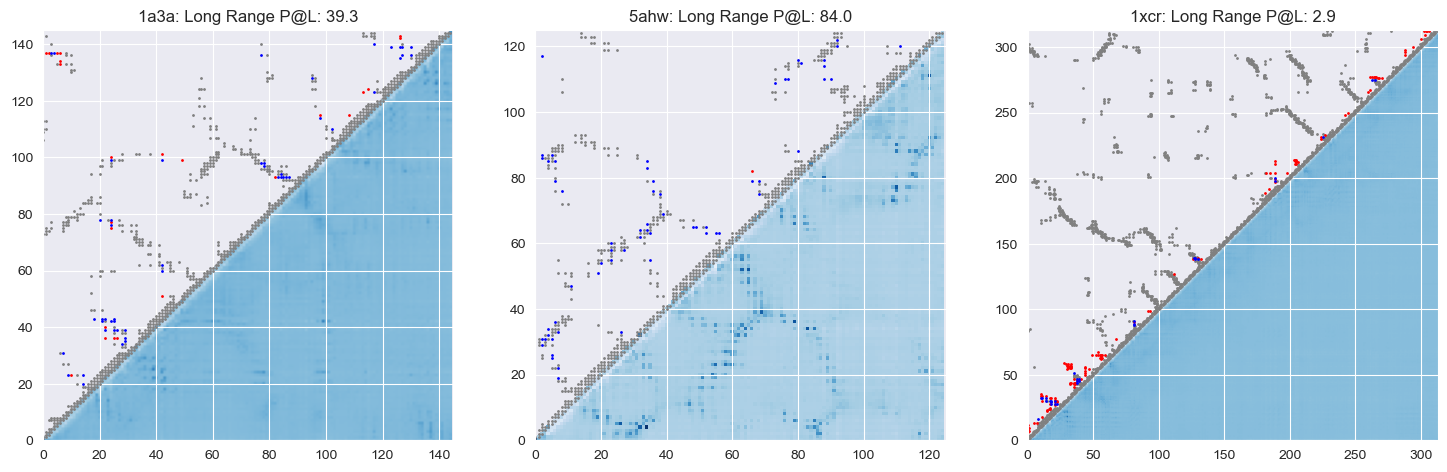

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM (Unsupervised),0.473591,0.358621,0.458333,0.620690,0.428934,0.241379,0.375000,0.655172,0.486386,0.296552,0.430556,0.758621,0.472737,0.393103,0.486111,0.448276
1,5ahw,ESM (Unsupervised),0.658321,0.512000,0.645161,0.800000,0.508541,0.280000,0.451613,0.880000,0.555290,0.328000,0.564516,0.760000,0.942872,0.840000,0.983871,1.000000
2,1xcr,ESM (Unsupervised),0.211544,0.162939,0.198718,0.274194,0.169886,0.118211,0.160256,0.241935,0.169768,0.118211,0.179487,0.209677,0.033479,0.028754,0.032051,0.048387


In [9]:
# esm 2
# model, alphabet, batch_converter, head = get_model(name="esm2_t33_650M_UR50D")
print(f"padding_idx:{model.padding_idx}, cls_idx:{model.cls_idx}, eos_idx:{model.eos_idx}, mask_idx:{model.mask_idx}")
results2 = predict_unsup_maps(model, alphabet, batch_converter, sequences, device=DEVICE, head=head)
results2

Using cache found in /Users/taha.kassabi/.cache/torch/hub/facebookresearch_esm_main


padding_idx:1, cls_idx:32, eos_idx:2, mask_idx:33
torch.Size([145, 145, 680])
torch.Size([125, 125, 680])
torch.Size([313, 313, 680])


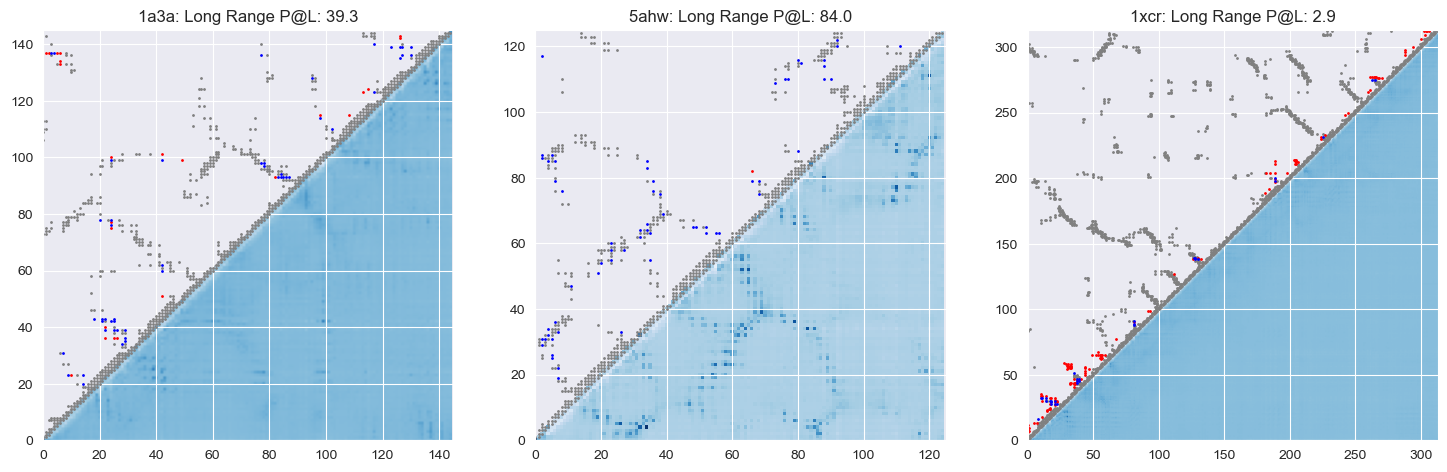

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM (Unsupervised),0.473591,0.358621,0.458333,0.620690,0.428934,0.241379,0.375000,0.655172,0.486386,0.296552,0.430556,0.758621,0.472737,0.393103,0.486111,0.448276
1,5ahw,ESM (Unsupervised),0.658321,0.512000,0.645161,0.800000,0.508541,0.280000,0.451613,0.880000,0.555290,0.328000,0.564516,0.760000,0.942872,0.840000,0.983871,1.000000
2,1xcr,ESM (Unsupervised),0.211544,0.162939,0.198718,0.274194,0.169886,0.118211,0.160256,0.241935,0.169768,0.118211,0.179487,0.209677,0.033479,0.028754,0.032051,0.048387


In [10]:
# esm 1
model, alphabet, batch_converter, head = get_model(name="esm1_t34_670M_UR50S")
print(f"padding_idx:{model.padding_idx}, cls_idx:{model.cls_idx}, eos_idx:{model.eos_idx}, mask_idx:{model.mask_idx}")
results1 = predict_unsup_maps(model, alphabet, batch_converter, sequences, device=DEVICE, head=head)
results1

Expected results

#### ESM2
| id   | model              |   local_AUC |   local_P@L |   local_P@L2 |   local_P@L5 |   short_AUC |   short_P@L |   short_P@L2 |   short_P@L5 |   medium_AUC |   medium_P@L |   medium_P@L2 |   medium_P@L5 |   long_AUC |   long_P@L |   long_P@L2 |   long_P@L5 |
|:-----|:-------------------|------------:|------------:|-------------:|-------------:|------------:|------------:|-------------:|-------------:|-------------:|-------------:|--------------:|--------------:|-----------:|-----------:|------------:|------------:|
| 1a3a | ESM (Unsupervised) |    0.801181 |    0.662069 |     0.805556 |     0.896552 |    0.528245 |    0.296552 |     0.5      |     0.827586 |     0.612222 |     0.344828 |      0.569444 |      0.931035 |   0.806507 |   0.689655 |    0.791667 |    0.931035 |
| 5ahw | ESM (Unsupervised) |    0.819763 |    0.68     |     0.83871  |     0.96     |    0.543314 |    0.296    |     0.5      |     0.84     |     0.569258 |     0.304    |      0.548387 |      0.92     |   0.937361 |   0.864    |    0.951613 |    0.96     |
| 1xcr | ESM (Unsupervised) |    0.529522 |    0.351438 |     0.5      |     0.693548 |    0.344734 |    0.204473 |     0.320513 |     0.516129 |     0.410161 |     0.265176 |      0.365385 |      0.596774 |   0.576668 |   0.408946 |    0.544872 |    0.758065 |


#### ESM1
| id   | model              |   local_AUC |   local_P@L |   local_P@L2 |   local_P@L5 |   short_AUC |   short_P@L |   short_P@L2 |   short_P@L5 |   medium_AUC |   medium_P@L |   medium_P@L2 |   medium_P@L5 |   long_AUC |   long_P@L |   long_P@L2 |   long_P@L5 |
|:-----|:-------------------|------------:|------------:|-------------:|-------------:|------------:|------------:|-------------:|-------------:|-------------:|-------------:|--------------:|--------------:|-----------:|-----------:|------------:|------------:|
| 1a3a | ESM (Unsupervised) |    0.473591 |    0.358621 |     0.458333 |     0.62069  |    0.428934 |    0.241379 |     0.375    |     0.655172 |     0.486386 |     0.296552 |      0.430556 |      0.758621 |  0.472737  |   0.393103 |   0.486111  |   0.448276  |
| 5ahw | ESM (Unsupervised) |    0.658321 |    0.512    |     0.645161 |     0.8      |    0.508541 |    0.28     |     0.451613 |     0.88     |     0.55529  |     0.328    |      0.564516 |      0.76     |  0.942871  |   0.84     |   0.983871  |   1         |
| 1xcr | ESM (Unsupervised) |    0.211544 |    0.162939 |     0.198718 |     0.274194 |    0.169886 |    0.118211 |     0.160256 |     0.241935 |     0.169768 |     0.118211 |      0.179487 |      0.209677 |  0.0334794 |   0.028754 |   0.0320513 |   0.0483871 |

### Visualization of data

Contact maps are only half of the story. To really know the structure of a protein we must know the 3D coordinates of each amino acid (or more precisely, of the $C_\beta$ atoms of the amino acids).

The contact maps are obtained by taking the 3D coordinates of each atom and calculating the distance between them. If the distance is less than a threshold, then the two atoms are said to be in contact. The threshold is usually set to 8 Angstroms.

Instead of using a binary threshold we can also bin the distances to obtain a *distogram*.
The distogram contains the structure information of the protein in an rotation and translation invariant way.

You will use the `esm_structural_train` and `esm_structural_valid` datasets in the rest of the exercise.
Each element of these datasets is a dictionary including the following keys:
- `seq`: the sequence of the protein (string length L)
- `dist`: the distances between the amino acids (numpy arrary of shape L x L)

Files already downloaded and verified
Files already downloaded and verified
Validation data: 2985 sequences, Training data: 12312 sequences


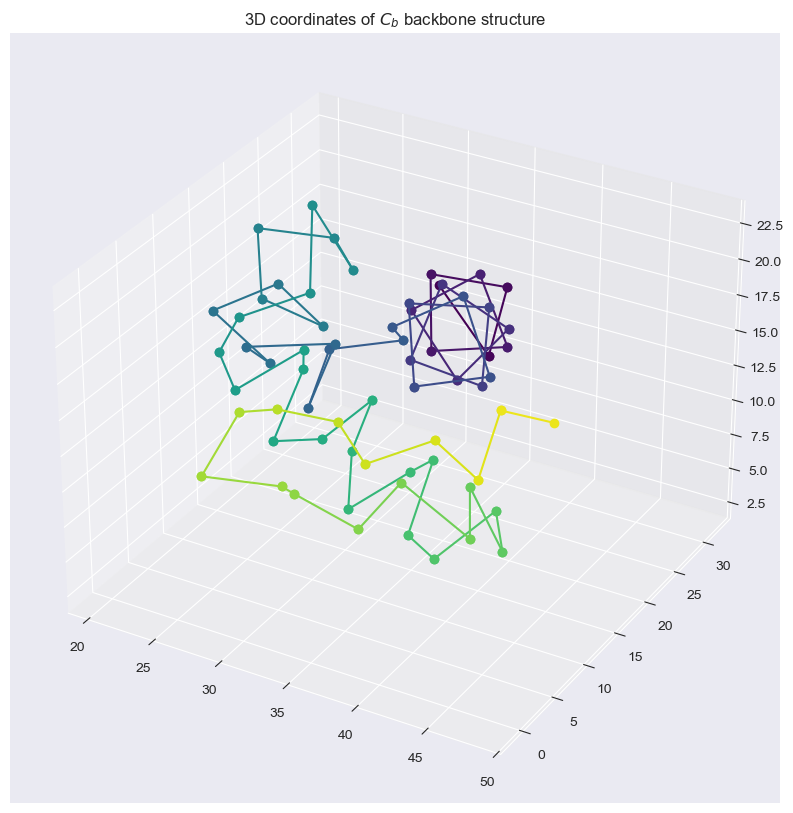

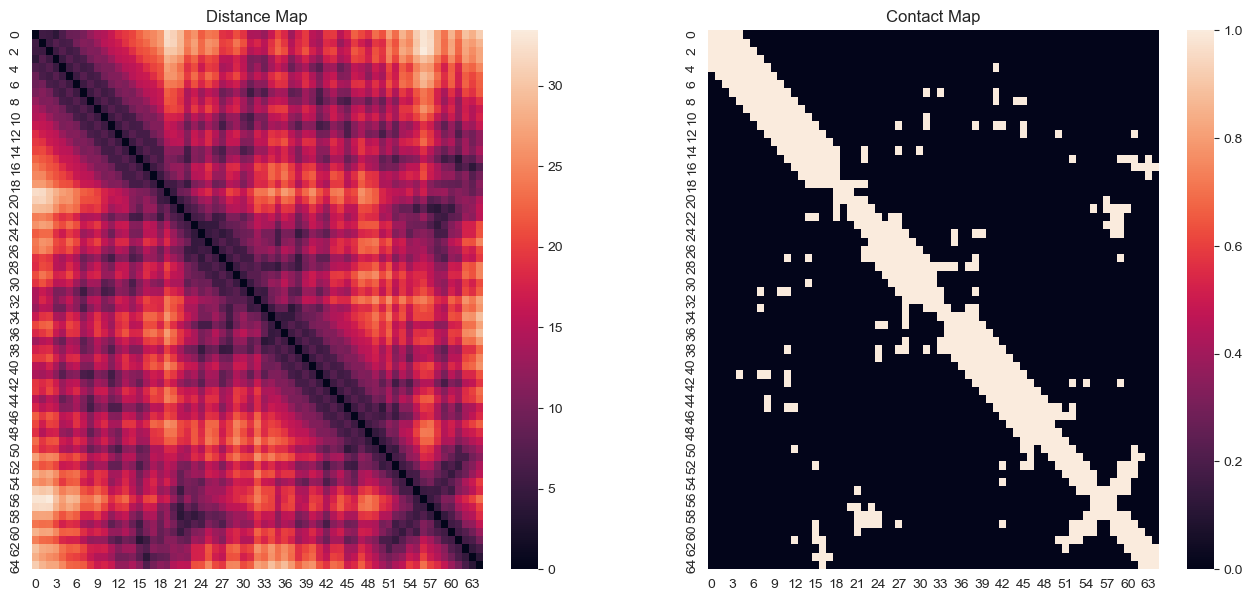

In [11]:
split_level = "superfamily"
cv_partition = '4'

esm_structural_train = ESMStructuralSplitDataset(
    split_level=split_level,
    cv_partition=cv_partition,
    split='train',
    root_path=os.path.expanduser('~/.cache/torch/data/esm'),
    download=True)
esm_structural_valid = ESMStructuralSplitDataset(
    split_level=split_level,
    cv_partition=cv_partition,
    split='valid',
    root_path=os.path.expanduser('~/.cache/torch/data/esm'),
    download=True)


def visualize_coords(coords):
    xs = coords[:, 0]
    ys = coords[:, 1]
    zs = coords[:, 2]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('3D coordinates of $C_{b}$ backbone structure')
    N = coords.shape[0]

    for i in range(coords.shape[0] - 1):
        ax.plot(
            xs[i:i + 2], ys[i:i + 2], zs[i:i + 2],
            color=plt.cm.viridis(i / N),
            marker='o')


def visualize_dist_contact_map(dist, threshold=8):
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    sns.heatmap(dist, ax=ax[0])
    sns.heatmap(dist < threshold, ax=ax[1])
    ax[0].set_title('Distance Map')
    ax[1].set_title('Contact Map')


print(f"Validation data: {len(esm_structural_valid)} sequences, Training data: {len(esm_structural_train)} sequences")
ele = esm_structural_train[0]
target = ele["dist"]
target = torch.from_numpy((target < 8)).float()

coords = ele['coords']
visualize_coords(coords)
visualize_dist_contact_map(ele['dist'])
plt.show()

# Part IV. Data loading

Complete the `DatasetAttMap` class below.

In [12]:
esm_structural_train[0]

{'seq': 'MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG',
 'ssp': 'XHHHHHHHHHHHHHHHHH-SS-B-HHHHHHHHTS-HHHHHHHHHHHHHHT---EEETTEEE--TT',
 'dist': array([[ 0.       ,  5.672883 ,  5.3963623, ..., 29.735804 , 28.270145 ,
         30.689615 ],
        [ 5.672883 ,  0.       ,  5.2699447, ..., 27.685184 , 26.66073  ,
         28.712353 ],
        [ 5.3963623,  5.2699447,  0.       , ..., 27.354692 , 25.488342 ,
         27.420412 ],
        ...,
        [29.735804 , 27.685184 , 27.354692 , ...,  0.       ,  4.573016 ,
          6.3108907],
        [28.270145 , 26.66073  , 25.488342 , ...,  4.573016 ,  0.       ,
          3.7951276],
        [30.689615 , 28.712353 , 27.420412 , ...,  6.3108907,  3.7951276,
          0.       ]], shape=(65, 65), dtype=float32),
 'coords': array([[28.975, 31.845, 13.632],
        [33.089, 31.254,  9.771],
        [34.22 , 31.731, 14.896],
        [29.829, 28.674, 15.864],
        [31.305, 25.763, 11.817],
        [36.511, 26.872, 13.069],
  

In [13]:
class DatasetAttMap(torch.utils.data.Dataset):
    def __init__(self, dataset, contact_maps=True, max_len=500):
        self.dataset = dataset
        self.alphabet = alphabet
        self.contact_maps = contact_maps
        self.crop_max_len_data(max_len)

    def crop_max_len_data(self, max_len):
        # Remove all sequences longer than max_len from `self.dataset`
        ### START CODE HERE ### (≈ 1 line of code)
        self.dataset.names = [
            name for i, name in enumerate(self.dataset.names)
            if len(self.dataset[i]['seq']) <= max_len
        ]
        ### END CODE HERE ###

    def __getitem__(self, idx):
        """
        Returns a triplet of (idx, seq, target) where:
            - idx: the index of the sequence in the dataset
            - seq: the sequence of the protein (string length L)
            - target: either the distance map (float torch.Tensor) if contact_map=True or the contact map (long torch.Tensor) if contact_map=False
        Compute the contact map using the 8 Angstrom threshold as described above.
        """
        ### START CODE HERE ### (≈ 7 lines of code)
        data = self.dataset[idx]
        seq = data['seq']
        dist = torch.from_numpy(data['dist'])
        target = (dist < 8).int() if self.contact_maps else dist.float()
        return idx, seq, target
        ### END CODE HERE ###

    def __len__(self):
        return len(self.dataset)

    def get_batch_indices(self, toks_per_batch):
        sizes = [(len(s["seq"]), i) for i, s in enumerate(self.dataset)]
        sizes.sort()
        batches = []
        buf = []
        max_len = 0

        def _flush_current_buf():
            nonlocal max_len, buf
            if len(buf) == 0:
                return
            batches.append(buf)
            buf = []
            max_len = 0

        for sz, i in sizes:
            if max(sz, max_len) * (len(buf) + 1) > toks_per_batch:
                _flush_current_buf()
            max_len = max(max_len, sz)
            buf.append(i)

        _flush_current_buf()
        random.shuffle(batches)
        return batches

In [14]:
# Test your code and set the training hyperparameters
# We will use the provided `BatchConverterContact`

@torch.no_grad()
def get_att_map(tokens, model, alphabet, last_n_layers):
    att_maps = postprocess_attention(model(tokens, need_head_weights=True)["attentions"],
                                     append_eos=alphabet.append_eos, eos_idx=alphabet.eos_idx, tokens=batch_tokens,
                                     remove_cls=alphabet.prepend_bos, last_n_layers=last_n_layers)
    return att_maps.squeeze()


@torch.no_grad()
def test_dataio(model, data_loader, alphabet, last_n_layers=5, device=DEVICE):
    model = model.to(device)
    for batch in data_loader:
        tokens, contacts = batch
        tokens = tokens.to(device)
        att_maps = get_att_map(tokens, model, alphabet, last_n_layers)
        assert att_maps.shape[-3:-1] == contacts.shape[-2:], "attention map length does not match contact map length"
        assert att_maps.shape[0] == contacts.shape[0], "batch size does not match"
        break


class Hparams():
    def __init__(self):
        self.max_len = 300
        self.num_workers = 2
        self.pin_memory = True
        self.shuffle = True
        self.name = "esm1_t12_85M_UR50S"  # esm1_t12_85M_UR50S, esm1_t34_670M_UR50S
        self.last_n_layers = 10
        self.heads = 12  # for esm1_t12_85M_UR50S
        self.head_dim = self.last_n_layers * self.heads
        self.toks_per_batch = 1000
        self.weight_term = 1
        self.lr = 1e-3
        self.wd = 1e-4
        self.num_epochs = 5
        self.classes = 2


config = Hparams()
model, alphabet, _, head = get_model(name=config.name)
batch_converter = BatchConverterContact(alphabet, truncation_seq_length=config.max_len)
dataset = DatasetAttMap(esm_structural_train, contact_maps=True, max_len=config.max_len)
print("Used data:", len(dataset), 'max len', config.max_len)
print(f" {config.name}, prepend_bos: {int(alphabet.prepend_bos)} append_eos:{int(alphabet.append_eos)}")

model = model.to(DEVICE)

print(f"Grouping by sequence length with maximum number of tokens per batch of {config.toks_per_batch}")
batches = DatasetAttMap.get_batch_indices(dataset, toks_per_batch=config.toks_per_batch)
data_loader = torch.utils.data.DataLoader(dataset, collate_fn=batch_converter, batch_sampler=batches)
%timeit test_dataio(model, data_loader, alphabet,last_n_layers=config.last_n_layers)

Using cache found in /Users/taha.kassabi/.cache/torch/hub/facebookresearch_esm_main


Used data: 10028 max len 300
 esm1_t12_85M_UR50S, prepend_bos: 1 append_eos:0
Grouping by sequence length with maximum number of tokens per batch of 1000
The slowest run took 5.31 times longer than the fastest. This could mean that an intermediate result is being cached.
141 ms ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Estimate the weighting term
Contacts and non-contacts don't occur with the same frequency in the dataset.
We can estimate the ratio of non-contacts to contacts in the dataset and use this to weight the loss function.

In [15]:
dataset = DatasetAttMap(esm_structural_train, contact_maps=True, max_len=config.max_len)
### START CODE HERE ### (≈ 5 lines of code)
mean = 0
for _, _, contacts in dataset: mean += contacts.float().mean()
ratio = len(dataset) / mean.item()
### END CODE HERE ###
print("non-padded ratio", ratio)
config.weight_term = ratio

non-padded ratio 13.783954214440358


Expected result:
`17.36562728881836`

# Part V. Train a linear layer to predict contact maps from ESM embeddings

Complete the code to train a linear layer to predict contact maps from ESM embeddings. Since the contacts and non-contacts are imbalanced, we will not use accuracy as the metric. Instead, we will use the F1 score, which is defined as follows:
$$
F_1 = \frac{2TP}{2TP + FP + FN}
$$
where $TP$ is the number of true positives (prediction is 1 and target is 1), $FP$ is the number of false positives (prediction is 1, but target is 0), and $FN$ is the number of false negatives (prediction is 0, but target is 1).

In [16]:
print("The head will be a linear layer with with input dim", config.head_dim, "and output dim", config.classes)

The head will be a linear layer with with input dim 120 and output dim 2


In [17]:
def f1_score(tp, fp, fn):
    return (2 * tp) / (2 * tp + fp + fn)


def train_one_epoch(model, head, optimizer, train_loader, criterion, device, config):
    model.train()
    loss_step = []
    tp, fp, fn = 0, 0, 0
    for batch in tqdm(train_loader, leave=False, desc="Training"):
        optimizer.zero_grad()
        # Tips
        # Do the forward and backward pass
        # Track the number of true positives, false positives, and false negatives and add them to `tp`, `fp`, and `fn`
        ### START CODE HERE ### (≈ 10 lines of code)
        tokens, contacts = batch
        tokens = tokens.to(device)
        contacts = contacts.to(device).long()

        att_maps = get_att_map(tokens, model, alphabet, config.last_n_layers)
        logits = head(att_maps)

        pred = logits.argmax(-1)
        tp += ((contacts == 1) & (pred == 1)).sum().detach()
        fp += ((contacts == 0) & (pred == 1)).sum().detach()
        fn += ((contacts == 1) & (pred == 0)).sum().detach()

        loss = criterion(logits.view(-1, config.classes), contacts.view(-1))
        loss.backward()
        optimizer.step()

        loss_step.append(loss.item())
        ### END CODE HERE ###
    loss_curr_epoch = np.mean(loss_step)
    train_f1 = f1_score(tp, fp, fn).cpu().item()
    return loss_curr_epoch, train_f1


@torch.no_grad()
def validate(model, head, val_loader, device, criterion):
    model.eval()
    tp, fp, fn = 0, 0, 0
    loss_step = []
    for batch in tqdm(val_loader, leave=False, desc="Validating"):
        ### START CODE HERE ### (≈ 7 lines of code)
        tokens, contacts = batch
        tokens = tokens.to(device)
        contacts = contacts.to(device).long()

        att_maps = get_att_map(tokens, model, alphabet, config.last_n_layers)
        logits = head(att_maps)

        pred = logits.argmax(-1)
        tp += ((contacts == 1) & (pred == 1)).sum().detach()
        fp += ((contacts == 0) & (pred == 1)).sum().detach()
        fn += ((contacts == 1) & (pred == 0)).sum().detach()

        loss = criterion(logits.view(-1, 2), contacts.view(-1))
        loss_step.append(loss.item())
    ### END CODE HERE ###
    val_f1 = f1_score(tp, fp, fn).cpu().item()
    val_loss_epoch = torch.tensor(loss_step).mean().numpy()
    return val_f1, val_loss_epoch

In [18]:
# GIVEN
def train(model, head, optimizer, config, train_loader, val_loader, criterion, device):
    best_val_loss = 1e8
    best_val_f1 = 0
    model = model.to(device)
    dict_log = {"train_f1_epoch": [], "val_f1_epoch": [], "loss_epoch": [], "val_loss": []}
    with tqdm(range(config.num_epochs), desc="Epoch") as pbar:
        for epoch in pbar:
            loss_curr_epoch, train_f1 = train_one_epoch(model, head, optimizer, train_loader, criterion, device, config)
            val_f1, val_loss = validate(model, head, val_loader, device, criterion)

            # Print epoch results to screen
            msg = f'F1 : Train:{train_f1:.2f} \t Val:{val_f1:.2f} || Loss: Train {loss_curr_epoch:.3f} \t Val {val_loss:.3f}'
            pbar.set_postfix_str(msg)
            # Track stats
            dict_log["train_f1_epoch"].append(train_f1)
            dict_log["val_f1_epoch"].append(val_f1)
            dict_log["loss_epoch"].append(loss_curr_epoch)
            dict_log["val_loss"].append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                }, models_dir / 'best_model_min_val_loss.pth')

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                }, models_dir / 'best_model_max_val_f1.pth')
    return dict_log

Using cache found in /Users/taha.kassabi/.cache/torch/hub/facebookresearch_esm_main


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1844 [00:00<?, ?it/s]

Validating:   0%|          | 0/427 [00:00<?, ?it/s]

Training:   0%|          | 0/1844 [00:00<?, ?it/s]

Validating:   0%|          | 0/427 [00:00<?, ?it/s]

Training:   0%|          | 0/1844 [00:00<?, ?it/s]

Validating:   0%|          | 0/427 [00:00<?, ?it/s]

Training:   0%|          | 0/1844 [00:00<?, ?it/s]

Validating:   0%|          | 0/427 [00:00<?, ?it/s]

Training:   0%|          | 0/1844 [00:00<?, ?it/s]

Validating:   0%|          | 0/427 [00:00<?, ?it/s]

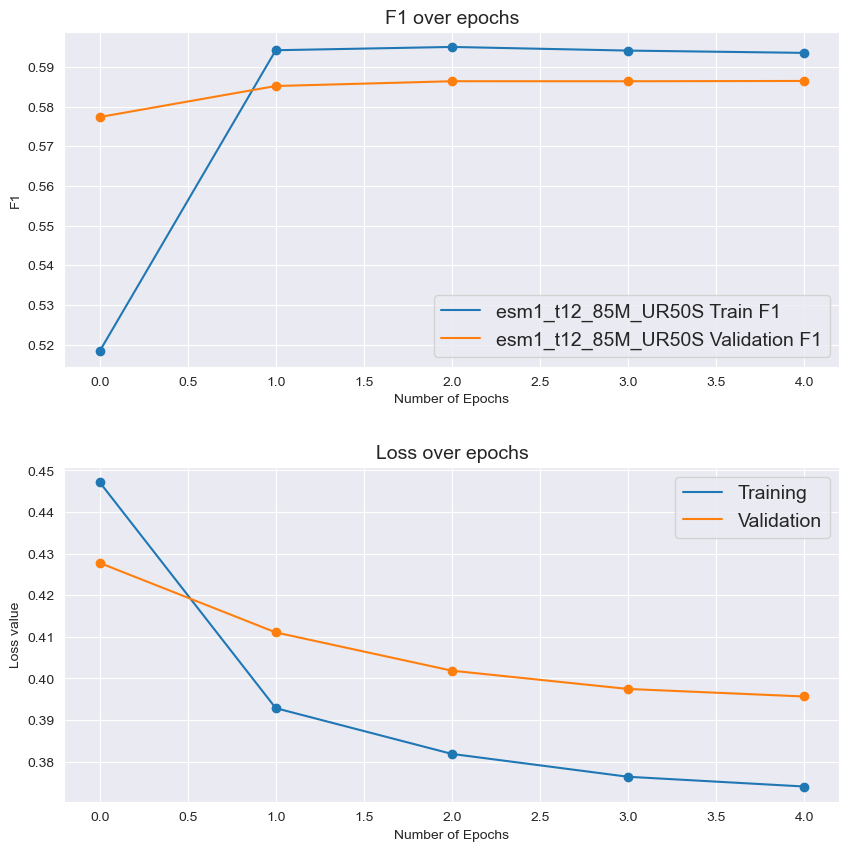

In [19]:
def main(device=DEVICE):
    dataset = DatasetAttMap(esm_structural_train, contact_maps=True, max_len=config.max_len)
    val_dataset = DatasetAttMap(esm_structural_valid, contact_maps=True, max_len=config.max_len)
    model, alphabet, _, _ = get_model(name=config.name)
    head = torch.nn.Linear(config.head_dim, config.classes, bias=True)
    batch_converter = BatchConverterContact(alphabet, truncation_seq_length=config.max_len)
    batches = DatasetAttMap.get_batch_indices(dataset, toks_per_batch=config.toks_per_batch)
    data_loader = torch.utils.data.DataLoader(dataset, collate_fn=batch_converter, batch_sampler=batches)
    val_batches = DatasetAttMap.get_batch_indices(val_dataset, toks_per_batch=config.toks_per_batch)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=batch_converter, batch_sampler=val_batches)
    model = model.to(device)
    head = head.to(device)
    optimizer = torch.optim.Adam(head.parameters(), lr=config.lr, weight_decay=config.wd)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, config.weight_term])).to(device)
    return train(model, head, optimizer, config, data_loader, val_data_loader, criterion, device=device)


dict_log = main(DEVICE)
plt.figure(figsize=(10, 10))
plot_stats(dict_log, modelname=config.name, title=figs_dir / "Contact Map Prediction {config.name}")

Expected validation F1 score: ~0.55

# Conclusion

That's the end of this exercise. If you reached this point, **congratulations**!

- Optional: Train with distograms instead of contact maps similar to [Verkuil, R., Kabeli, O., Du, Y., Wicky, B. I., Milles, L. F., Dauparas, J., ... & Rives, A. (2022). Language models generalize beyond natural proteins. bioRxiv, 2022-12.](https://www.biorxiv.org/content/10.1101/2022.12.21.521521v1.full.pdf)